# CSE428 Lab Project — Brain Tumor MRI Classification + Segmentation (BRISC2025)


## 0. Environment Check (PyTorch / CUDA)

In [18]:
import torch
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("WARNING: GPU not detected!")

PyTorch Version: 2.5.1+cu121
CUDA Available: True
GPU Name: NVIDIA GeForce RTX 3060


## 1. Dataset Download / Path Configuration

In [19]:
import os

MANUAL_DATASET_PATH = r"E:\brisc2025"

if os.path.exists(MANUAL_DATASET_PATH):
    path = MANUAL_DATASET_PATH
    print("Using MANUAL_DATASET_PATH:", path)
else:
    try:
        import kagglehub
        path = kagglehub.dataset_download("briscdataset/brisc2025")
        print("Downloaded dataset to:", path)
    except Exception as e:
        raise RuntimeError(
            "Could not find MANUAL_DATASET_PATH and kagglehub download failed. "
            "Please set MANUAL_DATASET_PATH to your dataset folder."
        ) from e


Using MANUAL_DATASET_PATH: E:\brisc2025


## 2. Imports & Global Configuration (Hyperparameters)

In [20]:
import sys
import time
import cv2
import numpy as np
import torch
import torch._dynamo
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import random
from contextlib import nullcontext
import time
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import random_split, Subset, DataLoader, Dataset
import torch._dynamo.external_utils
import torch.nn as nn
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

IMAGE_SIZE = 256
BATCH_SIZE = 8
NUM_EPOCHS = 20
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print("Libraries installed and imported successfully!")
print(f"OpenCV Version: {cv2.__version__}")
print(f"PyTorch Version: {torch.__version__}")
print(f"Device set to: {DEVICE}")

ENABLE_DENOISE = False
DENOISE_METHOD = "median"
ENABLE_MASK_MORPH_CLEAN = False

LOG_TEST_CURVES = True

print('Hyperparameters:', dict(IMAGE_SIZE=IMAGE_SIZE, BATCH_SIZE=BATCH_SIZE, NUM_EPOCHS=NUM_EPOCHS, LEARNING_RATE=LEARNING_RATE))

Libraries installed and imported successfully!
OpenCV Version: 4.12.0
PyTorch Version: 2.5.1+cu121
Device set to: cuda
Hyperparameters: {'IMAGE_SIZE': 256, 'BATCH_SIZE': 8, 'NUM_EPOCHS': 20, 'LEARNING_RATE': 0.0001}


## 3. Model Design — U-Net + Classifier Head and Attention U-Net

In [21]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNetMultiTask(nn.Module):
    def __init__(self, n_channels=1, seg_classes=1, cls_classes=4):
        super(UNetMultiTask, self).__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512))
        self.down4 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(512, 1024))

        # ---- classification head (4 classes) ----
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, cls_classes)   # <-- was n_classes
        )

        # ---- decoder for segmentation ----
        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(1024, 512)
        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(512, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(256, 128)
        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(128, 64)

        self.outc = nn.Conv2d(64, seg_classes, kernel_size=1)  # <-- was n_classes

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        class_out = self.classifier(self.global_pool(x5))  # (B, 4)

        x = self.up1(x5)
        x = torch.cat([x4, x], dim=1)
        x = self.conv1(x)
        x = self.up2(x)
        x = torch.cat([x3, x], dim=1)
        x = self.conv2(x)
        x = self.up3(x)
        x = torch.cat([x2, x], dim=1)
        x = self.conv3(x)
        x = self.up4(x)
        x = torch.cat([x1, x], dim=1)
        x = self.conv4(x)

        seg_out = self.outc(x)  # (B, 1, H, W)
        return seg_out, class_out


class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True), nn.BatchNorm2d(F_int))
        self.W_x = nn.Sequential(nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True), nn.BatchNorm2d(F_int))
        self.psi = nn.Sequential(nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True), nn.BatchNorm2d(1), nn.Sigmoid())
        self.relu = nn.ReLU(inplace=True)
    def forward(self, g, x):
        return x * self.psi(self.relu(self.W_g(g) + self.W_x(x)))


class AttentionUNetSeg(nn.Module):
    def __init__(self, n_channels=1, n_classes=1):
        super().__init__()

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512))
        self.down4 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(512, 1024))

        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.att1 = AttentionBlock(F_g=512, F_l=512, F_int=256)
        self.conv1 = DoubleConv(1024, 512)

        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.att2 = AttentionBlock(F_g=256, F_l=256, F_int=128)
        self.conv2 = DoubleConv(512, 256)

        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.att3 = AttentionBlock(F_g=128, F_l=128, F_int=64)
        self.conv3 = DoubleConv(256, 128)

        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.att4 = AttentionBlock(F_g=64, F_l=64, F_int=32)
        self.conv4 = DoubleConv(128, 64)

        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        g = self.up1(x5)
        x4a = self.att1(g=g, x=x4)
        x = self.conv1(torch.cat([x4a, g], dim=1))

        g = self.up2(x)
        x3a = self.att2(g=g, x=x3)
        x = self.conv2(torch.cat([x3a, g], dim=1))

        g = self.up3(x)
        x2a = self.att3(g=g, x=x2)
        x = self.conv3(torch.cat([x2a, g], dim=1))

        g = self.up4(x)
        x1a = self.att4(g=g, x=x1)
        x = self.conv4(torch.cat([x1a, g], dim=1))

        seg_out = self.outc(x)
        return seg_out


## 4. Loss Functions

In [22]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        return 1 - dice


def _masked_dice_loss(seg_pred, seg_target, has_mask=None):
    if has_mask is None:
        return DiceLoss()(seg_pred, seg_target)

    hm = has_mask.view(-1).bool()
    if hm.sum() == 0:
        return seg_pred.sum() * 0.0

    return DiceLoss()(seg_pred[hm], seg_target[hm])



def criterion(seg_pred, class_pred, seg_target, class_target, has_mask=None):
    dice_loss  = _masked_dice_loss(seg_pred, seg_target, has_mask)
    class_loss = nn.CrossEntropyLoss()(class_pred, class_target)
    return dice_loss + class_loss

def seg_criterion(seg_pred, seg_target, has_mask=None):
    return _masked_dice_loss(seg_pred, seg_target, has_mask)



## 5. Dataset Review & Preprocessing Pipeline

In [23]:
def _normalize_id(stem: str) -> str:
    s = stem.lower()
    for suf in ["_mask", "-mask", "_seg", "-seg", "_gt", "-gt", "_label", "-label"]:
        if s.endswith(suf):
            s = s[:-len(suf)]
    return s

CLASS_TO_IDX = {
    "no_tumor": 0,
    "glioma": 1,
    "meningioma": 2,
    "pituitary": 3,
}

def _infer_multiclass_label_from_path(img_path: str) -> int:
    parts = [p.lower() for p in img_path.split(os.sep)]

    # folder-based
    for k, v in CLASS_TO_IDX.items():
        if k in parts or k.replace("_", "-") in parts:
            return v

    # filename-based fallback
    name = os.path.basename(img_path).lower()
    if "no_tumor" in name or "notumor" in name or "_nt_" in name:
        return 0
    if "glioma" in name or "_gl_" in name:
        return 1
    if "meningioma" in name or "_me_" in name:
        return 2
    if "pituitary" in name or "_pi_" in name:
        return 3

    # if unknown, default to tumor (or raise error)
    return 1


def find_brisc2025_base(start_path: str) -> str:
    if os.path.isdir(os.path.join(start_path, "segmentation_task")) or os.path.isdir(os.path.join(start_path, "classification_task")):
        return start_path

    for root, dirs, _ in os.walk(start_path):
        if "segmentation_task" in dirs or "classification_task" in dirs:
            return root
    return start_path

def _collect_image_files(root_dir: str):
    exts = ("*.png", "*.jpg", "*.jpeg", "*.bmp", "*.tif", "*.tiff")
    files = []
    for ext in exts:
        files.extend(glob.glob(os.path.join(root_dir, "**", ext), recursive=True))
    files = [p for p in files if "mask" not in p.lower().split(os.sep)]
    return sorted(files)

def _build_mask_map(seg_task_dir: str):
    mask_map = {}
    if not os.path.isdir(seg_task_dir):
        return mask_map

    mask_dir = None
    cand = os.path.join(seg_task_dir, "masks")
    if os.path.isdir(cand):
        mask_dir = cand
    else:
        for root, dirs, _ in os.walk(seg_task_dir):
            if "masks" in dirs:
                mask_dir = os.path.join(root, "masks")
                break

    if mask_dir is None:
        return mask_map

    for p in _collect_image_files(mask_dir):
        stem = os.path.splitext(os.path.basename(p))[0]
        key = _normalize_id(stem)
        mask_map[key] = p
    return mask_map


class BrainTumorDataset(Dataset):
    def __init__(self, start_path, mode="train", img_size=256):
        self.mode = mode
        self.img_size = img_size

        base = find_brisc2025_base(start_path)
        self.base_dir = base
        cls_task = os.path.join(base, "classification_task")
        seg_task = os.path.join(base, "segmentation_task")

        if os.path.isdir(cls_task):
            img_files = _collect_image_files(cls_task)
        else:
            img_files = []

        if len(img_files) == 0 and os.path.isdir(seg_task):
            img_dir = os.path.join(seg_task, "images")
            if os.path.isdir(img_dir):
                img_files = _collect_image_files(img_dir)
            else:
                img_files = _collect_image_files(seg_task)

        if len(img_files) == 0:
            raise FileNotFoundError(
                f"No image files found. Checked: {cls_task} and {seg_task}. Base detected: {base}"
            )
        self.mask_map = _build_mask_map(seg_task)
        self.records = []
        for p in img_files:
            stem = os.path.splitext(os.path.basename(p))[0]
            key = _normalize_id(stem)
            label_val = _infer_multiclass_label_from_path(p)
            mask_path = self.mask_map.get(key, None)
            has_mask = 1 if (mask_path is not None or label_val == 0) else 0
            self.records.append((p, mask_path, label_val, has_mask))

        total = len(self.records)
        with_mask = sum(1 for _, m, _, _ in self.records if m is not None)
        supervised = sum(h for *_, h in self.records)
        tumors = sum(1 for *_, y, _h in self.records if y != 0)
        notum  = sum(1 for *_, y, _h in self.records if y == 0)


        print(f"[BRISC Dataset] base={self.base_dir}")
        print(f"  - total images: {total}")
        print(f"  - masks found by filename match: {with_mask}")
        print(f"  - seg-supervised samples (has_mask=1): {supervised}")
        print(f"  - label balance (binary): tumor={tumors}, no_tumor={notum}")

        self.has_mask_flags = [rec[3] for rec in self.records]
        #albumentations
        if self.mode == "train":
            self.transform = A.Compose([
                A.Resize(self.img_size, self.img_size),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.2),
                A.Rotate(limit=15, p=0.3),
                A.Normalize(mean=(0.5,), std=(0.5,)),
                ToTensorV2()
            ])
        else:
            self.transform = A.Compose([
                A.Resize(self.img_size, self.img_size),
                A.Normalize(mean=(0.5,), std=(0.5,)),
                ToTensorV2()
            ])

    def __len__(self):
        return len(self.records)

    def __getitem__(self, idx):
        img_path, mask_path, label_val, has_mask = self.records[idx]

        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            image = np.zeros((self.img_size, self.img_size), dtype=np.uint8)

        if mask_path is None:
            mask = np.zeros_like(image, dtype=np.uint8)
        else:
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is None:
                mask = np.zeros_like(image, dtype=np.uint8)


        if ENABLE_DENOISE:
            try:
                if DENOISE_METHOD.lower() == "median":
                    image = cv2.medianBlur(image, 3)
                elif DENOISE_METHOD.lower() == "gaussian":
                    image = cv2.GaussianBlur(image, (3, 3), 0)
            except Exception as e:
                print("Denoise failed:", repr(e))

        if ENABLE_MASK_MORPH_CLEAN and mask_path is not None:
            try:
                kernel = np.ones((3, 3), np.uint8)
                mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
            except Exception as e:
                print("Mask morphology failed:", repr(e))

        augmented = self.transform(image=image, mask=mask)
        image = augmented["image"]
        mask  = augmented["mask"]

        if image.ndim == 2:
            image = image.unsqueeze(0)
        elif image.ndim == 3 and image.shape[0] != 1:
            image = image[:1]

        if mask.ndim == 3:
            mask = mask[0]
        mask = (mask > 0).float().unsqueeze(0)

        label = torch.tensor(label_val, dtype=torch.long)   # shape: (), values 0..3
        has_mask_t = torch.tensor([float(has_mask)], dtype=torch.float32)
        return image, mask, label, has_mask_t


## 6. Dataset Split Summary

In [24]:
def summarize_split(ds, indices, name="split", plot=True, save_dir=None):
    labels = np.array([ds.records[i][2] for i in indices], dtype=int)
    hasm   = np.array([ds.records[i][3] for i in indices], dtype=int)

    tumor = int((labels != 0).sum())
    no_t  = int((labels == 0).sum())
    total = int(len(indices))

    seg_sup = int(hasm.sum())

    print(
        f"[{name}] total={total} | "
        f"tumor={tumor} ({tumor/total:.1%}) | "
        f"no_tumor={no_t} ({no_t/total:.1%}) | "
        f"seg-supervised={seg_sup} ({seg_sup/total:.1%})"
    )

    if plot:
        plt.figure(figsize=(4.5, 3))
        plt.bar(["no_tumor", "tumor"], [no_t, tumor])
        plt.title(f"Class Balance — {name}")
        plt.tight_layout()
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            plt.savefig(os.path.join(save_dir, f"{name}_class_balance.png"), dpi=200)
        plt.show()

        plt.figure(figsize=(4.5, 3))
        plt.bar(["no_GT_mask", "has_GT_mask"], [total - seg_sup, seg_sup])
        plt.title(f"Seg Supervision Balance — {name}")
        plt.tight_layout()
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            plt.savefig(os.path.join(save_dir, f"{name}_seg_supervision.png"), dpi=200)
        plt.show()

    return {"total": total, "tumor": tumor, "no_tumor": no_t, "seg_supervised": seg_sup}


## 7. Training Strategy & Training Loop

In [25]:
def dice_score_from_logits(seg_logits, seg_target, has_mask=None, threshold=0.5, eps=1e-6):
    prob = torch.sigmoid(seg_logits)
    pred = (prob > threshold).float()

    if has_mask is not None:
        hm = has_mask.view(-1).float()
        keep = (hm > 0.5).nonzero(as_tuple=True)[0]
        if keep.numel() == 0:
            return float("nan")
        pred = pred[keep]
        seg_target = seg_target[keep]

    pred_f = pred.view(pred.size(0), -1)
    targ_f = seg_target.view(seg_target.size(0), -1)

    inter = (pred_f * targ_f).sum(dim=1)
    denom = pred_f.sum(dim=1) + targ_f.sum(dim=1)
    dice = (2 * inter + eps) / (denom + eps)
    return float(dice.mean().item())

def cls_accuracy_from_logits(cls_logits, cls_target):
    pred = cls_logits.argmax(dim=1)  # (B,)
    return float((pred == cls_target).float().mean().item())


@torch.no_grad()
def _eval_one_epoch(model, loader, task="multitask"):
    model.eval()
    loss_sum = 0.0
    dice_vals = []
    acc_vals = []

    for images, masks, labels, has_mask in loader:
        images = images.to(DEVICE)
        masks  = masks.to(DEVICE)
        labels = labels.to(DEVICE)
        has_mask = has_mask.to(DEVICE) if has_mask is not None else None

        if task == "multitask":
            seg_logits, cls_logits = model(images)
            loss = criterion(seg_logits, cls_logits, masks, labels, has_mask=has_mask)
            acc_vals.append(cls_accuracy_from_logits(cls_logits, labels))
        else:
            seg_logits = model(images)
            loss = seg_criterion(seg_logits, masks, has_mask=has_mask)

        loss_sum += float(loss.item())
        dice_vals.append(dice_score_from_logits(seg_logits, masks, has_mask=has_mask))

    avg_loss = loss_sum / max(len(loader), 1)
    avg_dice = float(np.nanmean(dice_vals)) if len(dice_vals) else float("nan")
    avg_acc  = float(np.nanmean(acc_vals)) if len(acc_vals) else float("nan")
    return avg_loss, avg_dice, avg_acc


def train_model(model,model_name,train_loader,val_loader, task="multitask", num_epochs=20, test_loader=None, log_test_curves=True):
    print(f"\n=== Training: {model_name} | task={task} ===")
    model.to(DEVICE)

    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=3)
    PATIENCE = 5
    best_val = float("inf")
    bad_epochs = 0

    use_amp = (DEVICE == "cuda")
    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
    amp_ctx = torch.cuda.amp.autocast if use_amp else nullcontext

    history = {
        "train_loss": [], "val_loss": [], "test_loss": [],
        "train_dice": [], "val_dice": [], "test_dice": [],
    }
    if task == "multitask":
        history.update({"train_acc": [], "val_acc": [], "test_acc": []})

    t0 = time.time()

    for epoch in range(num_epochs):
        model.train()
        train_loss_sum = 0.0
        train_dice_vals = []
        train_acc_vals = []

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
        for images, masks, labels, has_mask in pbar:
            images = images.to(DEVICE)
            masks  = masks.to(DEVICE)
            labels = labels.to(DEVICE)
            has_mask = has_mask.to(DEVICE) if has_mask is not None else None

            optimizer.zero_grad(set_to_none=True)

            with amp_ctx():
                if task == "multitask":
                    seg_logits, cls_logits = model(images)
                    loss = criterion(seg_logits, cls_logits, masks, labels, has_mask=has_mask)
                else:
                    seg_logits = model(images)
                    loss = seg_criterion(seg_logits, masks, has_mask=has_mask)

            if use_amp:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()

            train_loss_sum += float(loss.item())
            train_dice_vals.append(dice_score_from_logits(seg_logits, masks, has_mask=has_mask))
            if task == "multitask":
                train_acc_vals.append(cls_accuracy_from_logits(cls_logits, labels))

            pbar.set_postfix(loss=float(loss.item()))

        train_loss = train_loss_sum / max(len(train_loader), 1)
        train_dice = float(np.nanmean(train_dice_vals)) if len(train_dice_vals) else float("nan")
        history["train_loss"].append(train_loss)
        history["train_dice"].append(train_dice)
        if task == "multitask":
            history["train_acc"].append(float(np.nanmean(train_acc_vals)) if len(train_acc_vals) else float("nan"))

        val_loss, val_dice, val_acc = _eval_one_epoch(model, val_loader, task=task)
        history["val_loss"].append(val_loss)
        history["val_dice"].append(val_dice)
        if task == "multitask":
            history["val_acc"].append(val_acc)

        if (test_loader is not None) and log_test_curves:
            test_loss, test_dice, test_acc = _eval_one_epoch(model, test_loader, task=task)
            history["test_loss"].append(test_loss)
            history["test_dice"].append(test_dice)
            if task == "multitask":
                history["test_acc"].append(test_acc)
        else:
            history["test_loss"].append(float("nan"))
            history["test_dice"].append(float("nan"))
            if task == "multitask":
                history["test_acc"].append(float("nan"))

        scheduler.step(val_loss)

        print(
            f"Epoch {epoch+1:02d} | "
            f"train_loss={train_loss:.4f} val_loss={val_loss:.4f} | "
            f"train_dice={train_dice:.4f} val_dice={val_dice:.4f}"
            + (f" | train_acc={history['train_acc'][-1]:.4f} val_acc={val_acc:.4f}" if task == "multitask" else "")
        )

        if val_loss < best_val:
            best_val = val_loss
            bad_epochs = 0
            torch.save(model.state_dict(), f"{model_name}_best.pth")
        else:
            bad_epochs += 1
            if bad_epochs >= PATIENCE:
                print("Early stopping triggered.")
                break

    torch.save(history, f"{model_name}_history.pth")
    print(f"Saved history: {model_name}_history.pth")
    print(f"Best checkpoint: {model_name}_best.pth")
    print(f"Training finished in {(time.time()-t0)/60:.1f} min")

    return history


## 8. Main Execution (Split → Load/Train Models)

Dataset base: E:\brisc2025


[BRISC Dataset] base=E:\brisc2025
  - total images: 6000
  - masks found by filename match: 860
  - seg-supervised samples (has_mask=1): 2067
  - label balance (binary): tumor=4793, no_tumor=1207
Split sizes => Train: 4200, Val: 600, Test: 1200
[BRISC Dataset] base=E:\brisc2025
  - total images: 6000
  - masks found by filename match: 860
  - seg-supervised samples (has_mask=1): 2067
  - label balance (binary): tumor=4793, no_tumor=1207
[BRISC Dataset] base=E:\brisc2025
  - total images: 6000
  - masks found by filename match: 860
  - seg-supervised samples (has_mask=1): 2067
  - label balance (binary): tumor=4793, no_tumor=1207
[BRISC Dataset] base=E:\brisc2025
  - total images: 6000
  - masks found by filename match: 860
  - seg-supervised samples (has_mask=1): 2067
  - label balance (binary): tumor=4793, no_tumor=1207

 Split summaries (class balance + seg supervision) 
[Train] total=4200 | tumor=3358 (80.0%) | no_tumor=842 (20.0%) | seg-supervised=1445 (34.4%)


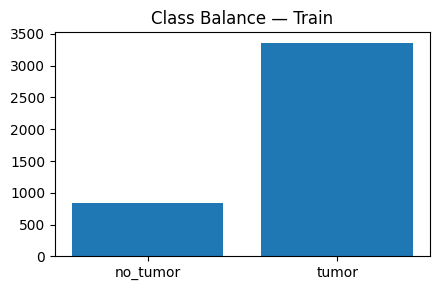

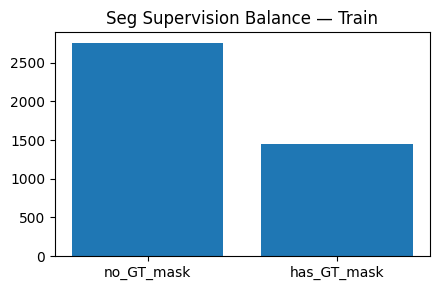

[Val] total=600 | tumor=468 (78.0%) | no_tumor=132 (22.0%) | seg-supervised=214 (35.7%)


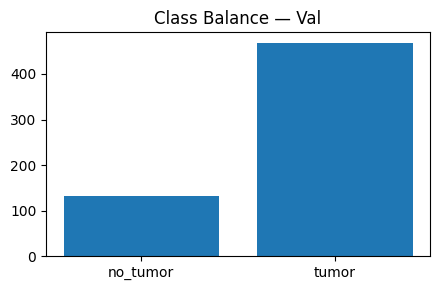

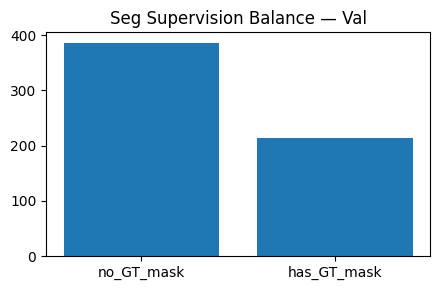

[Test] total=1200 | tumor=967 (80.6%) | no_tumor=233 (19.4%) | seg-supervised=408 (34.0%)


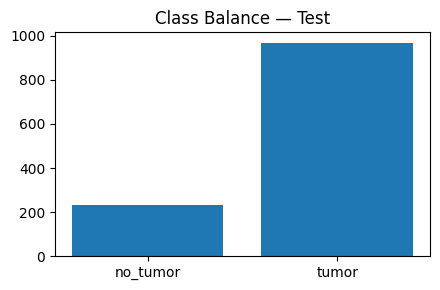

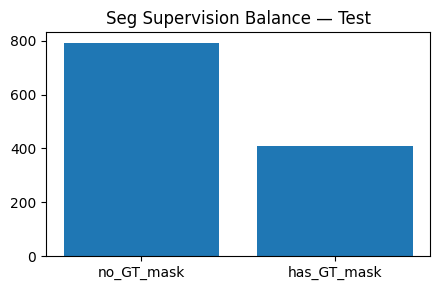

Seg-supervised counts => Train: 1445 / 4200, Val: 214 / 600, Test: 408 / 1200
[TRAIN] Training unet_multitask_4cls ...

=== Training: unet_multitask_4cls | task=multitask ===


C:\Users\User\AppData\Local\Temp\ipykernel_23516\380103210.py:67: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
Epoch 1/20:   0%|          | 0/525 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_23516\380103210.py:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp_ctx():


Epoch 01 | train_loss=1.7165 val_loss=1.7951 | train_dice=0.0449 val_dice=0.0496 | train_acc=0.6902 val_acc=0.6467


Epoch 02 | train_loss=1.5553 val_loss=1.3680 | train_dice=0.1172 val_dice=0.4432 | train_acc=0.7507 val_acc=0.8033


Epoch 03 | train_loss=1.4213 val_loss=1.4784 | train_dice=0.2669 val_dice=0.3198 | train_acc=0.7933 val_acc=0.7900


Epoch 04 | train_loss=1.3238 val_loss=1.5999 | train_dice=0.4588 val_dice=0.5788 | train_acc=0.8129 val_acc=0.7500


Epoch 05 | train_loss=1.1827 val_loss=1.4948 | train_dice=0.6078 val_dice=0.6972 | train_acc=0.8340 val_acc=0.7267


Epoch 06 | train_loss=1.0658 val_loss=0.9807 | train_dice=0.6687 val_dice=0.7826 | train_acc=0.8526 val_acc=0.8533


Epoch 07 | train_loss=1.0134 val_loss=0.9124 | train_dice=0.7034 val_dice=0.7984 | train_acc=0.8560 val_acc=0.8800


Epoch 08 | train_loss=0.9248 val_loss=0.8521 | train_dice=0.7219 val_dice=0.7876 | train_acc=0.8721 val_acc=0.8683


Epoch 09 | train_loss=0.9007 val_loss=0.8484 | train_dice=0.7365 val_dice=0.7944 | train_acc=0.8810 val_acc=0.9067


Epoch 10 | train_loss=0.8484 val_loss=0.8148 | train_dice=0.7620 val_dice=0.7805 | train_acc=0.8881 val_acc=0.9083


Epoch 11 | train_loss=0.8688 val_loss=0.8768 | train_dice=0.7485 val_dice=0.8218 | train_acc=0.8838 val_acc=0.8817


Epoch 12 | train_loss=0.8109 val_loss=0.9069 | train_dice=0.7625 val_dice=0.6767 | train_acc=0.9026 val_acc=0.9017


Epoch 13 | train_loss=0.8163 val_loss=0.7248 | train_dice=0.7765 val_dice=0.7832 | train_acc=0.8990 val_acc=0.9350


Epoch 14 | train_loss=0.7960 val_loss=0.7499 | train_dice=0.7744 val_dice=0.7472 | train_acc=0.9100 val_acc=0.9300


Epoch 15 | train_loss=0.7356 val_loss=0.7209 | train_dice=0.8077 val_dice=0.8328 | train_acc=0.9181 val_acc=0.9433


Epoch 16 | train_loss=0.7418 val_loss=0.6528 | train_dice=0.8021 val_dice=0.8463 | train_acc=0.9152 val_acc=0.9550


Epoch 17 | train_loss=0.7013 val_loss=0.8080 | train_dice=0.8211 val_dice=0.6947 | train_acc=0.9224 val_acc=0.9000


Epoch 18 | train_loss=0.6782 val_loss=0.6566 | train_dice=0.8131 val_dice=0.8429 | train_acc=0.9267 val_acc=0.9617


Epoch 19 | train_loss=0.6982 val_loss=0.6790 | train_dice=0.8204 val_dice=0.8404 | train_acc=0.9288 val_acc=0.9350


C:\Users\User\AppData\Local\Temp\ipykernel_23516\2211822470.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_location=DEV

Epoch 20 | train_loss=0.6740 val_loss=0.7632 | train_dice=0.8251 val_dice=0.8334 | train_acc=0.9388 val_acc=0.9067
Saved history: unet_multitask_4cls_history.pth
Best checkpoint: unet_multitask_4cls_best.pth
Training finished in 41.3 min
[TRAIN] Training attention_unet_seg ...

=== Training: attention_unet_seg | task=seg ===


Epoch 01 | train_loss=0.9589 val_loss=0.9599 | train_dice=0.0748 val_dice=0.0612


Epoch 02 | train_loss=0.9421 val_loss=0.9392 | train_dice=0.2227 val_dice=0.4699


Epoch 03 | train_loss=0.9271 val_loss=0.9441 | train_dice=0.3192 val_dice=0.0794


Epoch 04 | train_loss=0.9018 val_loss=0.9007 | train_dice=0.3993 val_dice=0.2545


Epoch 05 | train_loss=0.8639 val_loss=0.8458 | train_dice=0.4682 val_dice=0.6758


Epoch 06 | train_loss=0.7915 val_loss=0.7617 | train_dice=0.5821 val_dice=0.7087


Epoch 07 | train_loss=0.7211 val_loss=0.7147 | train_dice=0.6158 val_dice=0.7006


Epoch 08 | train_loss=0.6517 val_loss=0.6496 | train_dice=0.6318 val_dice=0.7580


Epoch 09 | train_loss=0.5904 val_loss=0.5498 | train_dice=0.6700 val_dice=0.7723


Epoch 10 | train_loss=0.5432 val_loss=0.5127 | train_dice=0.7083 val_dice=0.7604


Epoch 11 | train_loss=0.4698 val_loss=0.4354 | train_dice=0.7519 val_dice=0.8263


Epoch 12 | train_loss=0.4384 val_loss=0.5184 | train_dice=0.7419 val_dice=0.7797


Epoch 13 | train_loss=0.4315 val_loss=0.4410 | train_dice=0.7205 val_dice=0.7938


Epoch 14 | train_loss=0.3870 val_loss=0.7134 | train_dice=0.7763 val_dice=0.7003


Epoch 15 | train_loss=0.3935 val_loss=0.3959 | train_dice=0.7629 val_dice=0.8162


Epoch 16 | train_loss=0.3671 val_loss=0.3629 | train_dice=0.7855 val_dice=0.8046


Epoch 17 | train_loss=0.3712 val_loss=0.3772 | train_dice=0.7711 val_dice=0.7882


Epoch 18 | train_loss=0.3652 val_loss=0.3249 | train_dice=0.7631 val_dice=0.8267


Epoch 19 | train_loss=0.3630 val_loss=0.3215 | train_dice=0.7933 val_dice=0.8063


Epoch 20 | train_loss=0.3487 val_loss=0.2839 | train_dice=0.7893 val_dice=0.8345
Saved history: attention_unet_seg_history.pth
Best checkpoint: attention_unet_seg_best.pth
Training finished in 15.8 min

DONE: Models ready.
- unet_multitask_best.pth
- attention_unet_seg_best.pth


In [26]:
FORCE_RETRAIN = True  # set True to force retraining even if checkpoints exist
SEED = 42

if "path" not in globals():
    raise RuntimeError("Dataset path not found. Run the dataset path cell first.")

real_root = find_brisc2025_base(path)
print("Dataset base:", real_root)

base_ds = BrainTumorDataset(real_root, mode="val", img_size=IMAGE_SIZE)

#(70/10/20)
n_total = len(base_ds)
train_size = int(0.70 * n_total)
val_size   = int(0.10 * n_total)
test_size  = n_total - train_size - val_size
print(f"Split sizes => Train: {train_size}, Val: {val_size}, Test: {test_size}")

g = torch.Generator().manual_seed(SEED)
train_base, val_base, test_base = random_split(base_ds, [train_size, val_size, test_size], generator=g)

train_idx = list(train_base.indices)
val_idx   = list(val_base.indices)
test_idx  = list(test_base.indices)

train_ds = BrainTumorDataset(real_root, mode="train", img_size=IMAGE_SIZE)
val_ds   = BrainTumorDataset(real_root, mode="val",   img_size=IMAGE_SIZE)
test_ds  = BrainTumorDataset(real_root, mode="val",   img_size=IMAGE_SIZE)

train_set = Subset(train_ds, train_idx)
val_set   = Subset(val_ds,   val_idx)
test_set  = Subset(test_ds,  test_idx)

pin = (DEVICE == "cuda")
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0, pin_memory=pin)
val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=pin)
test_loader  = DataLoader(test_set,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=pin)

print("\n Split summaries (class balance + seg supervision) ")
split_train = summarize_split(base_ds, train_idx, name="Train", plot=True)
split_val   = summarize_split(base_ds, val_idx,   name="Val",   plot=True)
split_test  = summarize_split(base_ds, test_idx,  name="Test",  plot=True)

SPLIT_STATS = {"train": split_train, "val": split_val, "test": split_test}

has_mask_flags = getattr(base_ds, "has_mask_flags", None)
if has_mask_flags is None:
    print("Attention U-Net will use full loaders.")
    train_seg_idx, val_seg_idx, test_seg_idx = train_idx, val_idx, test_idx
else:
    train_seg_idx = []
    for i in train_idx:
        if has_mask_flags[i] == 1:
            train_seg_idx.append(i)

    val_seg_idx = []
    for i in val_idx:
        if has_mask_flags[i] == 1:
            val_seg_idx.append(i)

    test_seg_idx = []
    for i in test_idx:
        if has_mask_flags[i] == 1:
            test_seg_idx.append(i)

print(f"Seg-supervised counts => Train: {len(train_seg_idx)} / {len(train_idx)}, "
      f"Val: {len(val_seg_idx)} / {len(val_idx)}, Test: {len(test_seg_idx)} / {len(test_idx)}")

train_seg_loader = DataLoader(Subset(train_ds, train_seg_idx), batch_size=BATCH_SIZE, shuffle=True,  num_workers=0, pin_memory=pin) if len(train_seg_idx) else train_loader
val_seg_loader   = DataLoader(Subset(val_ds,   val_seg_idx),   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=pin) if len(val_seg_idx) else val_loader
test_seg_loader  = DataLoader(Subset(test_ds,  test_seg_idx),  batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=pin) if len(test_seg_idx) else test_loader

def load_or_train(model, model_name, task, tr_loader, va_loader, te_loader):
    ckpt_path = f"{model_name}_best.pth"

    if (not FORCE_RETRAIN) and os.path.exists(ckpt_path):
        print(f"[LOAD] {ckpt_path} found loading weights.")
        model.load_state_dict(torch.load(ckpt_path, map_location=DEVICE))
    else:
        print(f"[TRAIN] Training {model_name} ...")
        train_model(model=model,model_name=model_name,train_loader=tr_loader,val_loader=va_loader,task=task,num_epochs=NUM_EPOCHS,test_loader=te_loader,log_test_curves=bool(globals().get("LOG_TEST_CURVES", True)),)
        model.load_state_dict(torch.load(ckpt_path, map_location=DEVICE))

    model.to(DEVICE).eval()
    return model

model_unet = load_or_train(UNetMultiTask(n_channels=1, seg_classes=1, cls_classes=4),model_name="unet_multitask_4cls",task="multitask",tr_loader=train_loader,va_loader=val_loader,te_loader=test_loader)

model_att = load_or_train(AttentionUNetSeg(),model_name="attention_unet_seg",task="seg",tr_loader=train_seg_loader,va_loader=val_seg_loader,te_loader=test_seg_loader)

print("\nDONE: Models ready.")
print("- unet_multitask_best.pth")
print("- attention_unet_seg_best.pth")


## 9. Curves (Train/Val/Test vs Epoch)

C:\Users\User\AppData\Local\Temp\ipykernel_23516\2125371116.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  history = torch.load(hist_path, map_location="cpu")


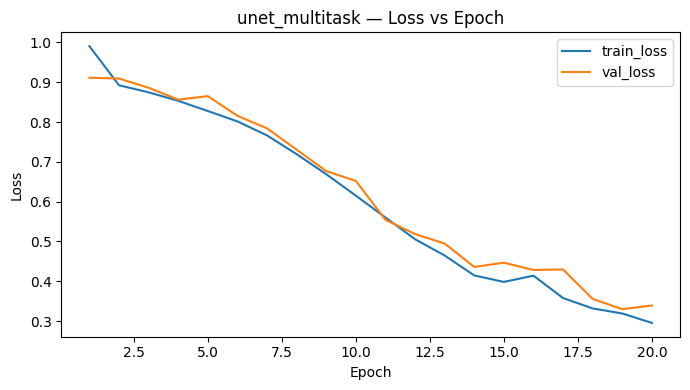

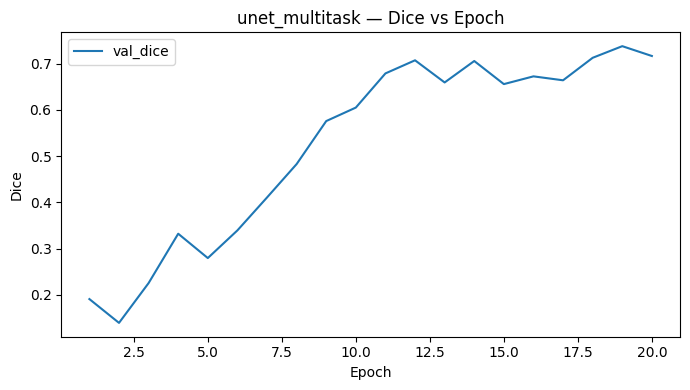

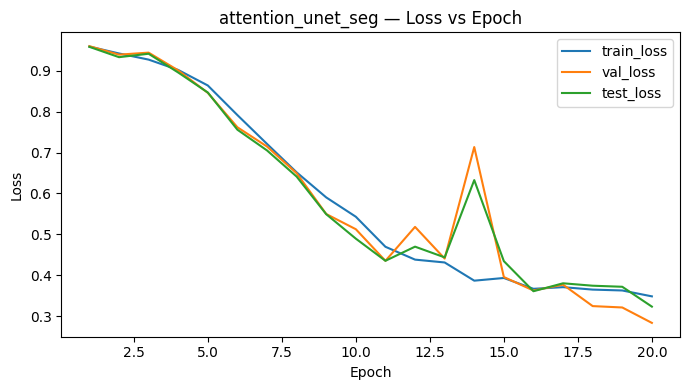

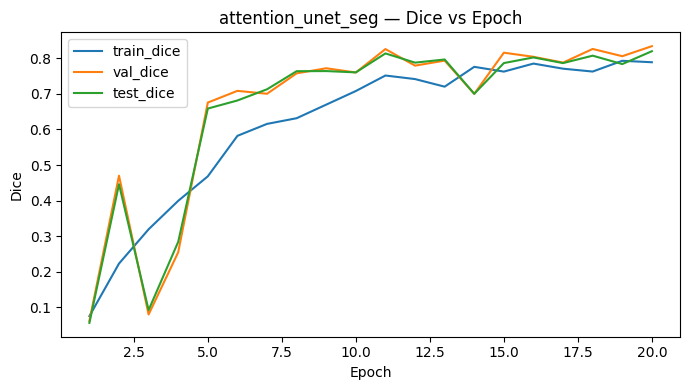

In [27]:
def plot_history(model_name):
    hist_path = f"{model_name}_history.pth"
    if not os.path.exists(hist_path):
        print(f"{hist_path} not found")
        return

    history = torch.load(hist_path, map_location="cpu")
    n = len(history.get("train_loss", []))
    epochs = list(range(1, n + 1))

    def _plot(keys, title, ylabel):
        plt.figure(figsize=(7,4))
        for k in keys:
            if k in history and len(history[k]) == n:
                plt.plot(epochs, history[k], label=k)
        plt.title(f"{model_name} — {title}")
        plt.xlabel("Epoch")
        plt.ylabel(ylabel)
        plt.legend()
        plt.tight_layout()
        plt.show()

    _plot(["train_loss","val_loss","test_loss"], "Loss vs Epoch", "Loss")
    _plot(["train_dice","val_dice","test_dice"], "Dice vs Epoch", "Dice")

    if "train_acc" in history:
        _plot(["train_acc","val_acc","test_acc"], "Accuracy vs Epoch", "Accuracy")

plot_history("unet_multitask")
plot_history("attention_unet_seg")



## 10. Evaluation Metrics (Train/Val/Test)

,model,split,seg_dice,seg_miou,seg_pixacc,cls_acc,cls_prec,cls_rec,cls_f1
0,U-Net (Seg+Class),Train,0.833155,0.789701,0.995498,0.959524,0.961833,0.960598,0.961172
1,U-Net (Seg+Class),Val,0.845864,0.806716,0.995472,0.955000,0.956857,0.952930,0.954677
2,U-Net (Seg+Class),Test,0.832002,0.788777,0.995257,0.955833,0.959233,0.958136,0.958330
3,Attention U-Net (Seg only),Train,0.807173,0.771361,0.995521,NaN,NaN,NaN,NaN
4,Attention U-Net (Seg only),Val,0.833792,0.802464,0.996136,NaN,NaN,NaN,NaN
5,Attention U-Net (Seg only),Test,0.820294,0.784071,0.995709,NaN,NaN,NaN,NaN


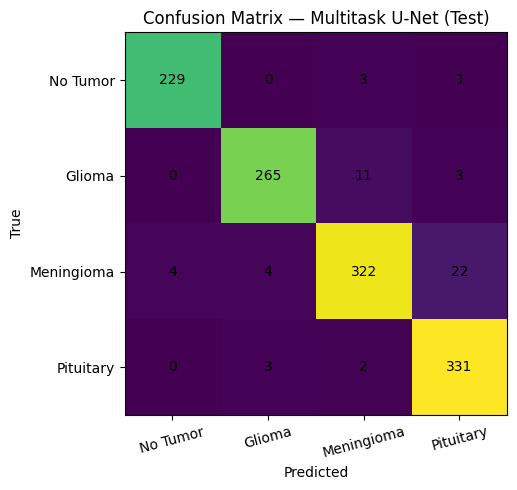

Multiclass AUC-OVR (macro, Test): 0.9965


In [28]:
try:
    from sklearn.metrics import (
        accuracy_score, precision_score, recall_score, f1_score,
        confusion_matrix, roc_auc_score
    )
    _SKLEARN_OK = True
except Exception as e:
    print("sklearn not available:", repr(e))
    _SKLEARN_OK = False

def _bin_from_logits(x, thr=0.5):
    return (torch.sigmoid(x) > thr).float()

@torch.no_grad()
def seg_metrics_from_logits(seg_logits, seg_target, eps=1e-6):
    """
    seg_logits: (B,1,H,W) or (1,1,H,W)
    seg_target: (B,1,H,W) or (1,1,H,W) with 0/1 (or 0..1)
    """
    pred = _bin_from_logits(seg_logits)
    true = (seg_target > 0.5).float()

    p = pred.view(-1)
    t = true.view(-1)

    tp = (p * t).sum()
    fp = (p * (1 - t)).sum()
    fn = ((1 - p) * t).sum()
    tn = ((1 - p) * (1 - t)).sum()

    dice = (2 * tp + eps) / (2 * tp + fp + fn + eps)
    iou  = (tp + eps) / (tp + fp + fn + eps)
    pix  = (tp + tn + eps) / (tp + tn + fp + fn + eps)

    return float(dice), float(iou), float(pix)


@torch.no_grad()
def evaluate_split(model, loader, task="multitask", device=DEVICE, split_name="split", n_classes=4):
    model.eval()
    metrics = {
        "seg_dice": [], "seg_iou": [], "seg_pixacc": [],
        "cls_probs": [], "cls_preds": [], "cls_targets": [],
    }

    for images, masks, labels, has_mask in tqdm(loader, desc=f"Eval {split_name}", leave=False):
        images = images.to(device)
        masks  = masks.to(device)
        labels = labels.to(device).long().view(-1)
        has_mask = has_mask.to(device).view(-1) if has_mask is not None else None

        if task == "multitask":
            seg_logits, cls_logits = model(images)

            probs_t = torch.softmax(cls_logits, dim=1)    
            preds_t = torch.argmax(probs_t, dim=1)          

            metrics["cls_probs"].extend(probs_t.detach().cpu().numpy().tolist())
            metrics["cls_preds"].extend(preds_t.detach().cpu().numpy().astype(np.int32).tolist())
            metrics["cls_targets"].extend(labels.detach().cpu().numpy().astype(np.int32).tolist())

        else:
            seg_logits = model(images)

        for i in range(images.size(0)):
            if has_mask is not None and int(has_mask[i].item()) == 0:
                continue
            d, iou, pix = seg_metrics_from_logits(seg_logits[i:i+1], masks[i:i+1])
            metrics["seg_dice"].append(d)
            metrics["seg_iou"].append(iou)
            metrics["seg_pixacc"].append(pix)

    out = {}
    out["seg_dice"]   = float(np.mean(metrics["seg_dice"])) if metrics["seg_dice"] else float("nan")
    out["seg_miou"]   = float(np.mean(metrics["seg_iou"])) if metrics["seg_iou"] else float("nan")
    out["seg_pixacc"] = float(np.mean(metrics["seg_pixacc"])) if metrics["seg_pixacc"] else float("nan")

    if task == "multitask":
        y_true = np.array(metrics["cls_targets"], dtype=int)
        y_pred = np.array(metrics["cls_preds"], dtype=int)
        y_prob = np.array(metrics["cls_probs"], dtype=float) 

        if len(y_true) > 0:
            if _SKLEARN_OK:
                out["cls_acc"]  = float(accuracy_score(y_true, y_pred))
                out["cls_prec"] = float(precision_score(y_true, y_pred, average="macro", zero_division=0))
                out["cls_rec"]  = float(recall_score(y_true, y_pred, average="macro", zero_division=0))
                out["cls_f1"]   = float(f1_score(y_true, y_pred, average="macro", zero_division=0))

                labels_list = list(range(n_classes))
                out["_cm"]     = confusion_matrix(y_true, y_pred, labels=labels_list)
                out["_y_true"] = y_true
                out["_y_prob"] = y_prob
            else:
                out["cls_acc"] = float((y_true == y_pred).mean())
        else:
            out["cls_acc"] = float("nan")

    return out


def _plot_confusion_matrix(
    cm,
    class_names=("No Tumor", "Glioma", "Meningioma", "Pituitary"),
    title="Confusion Matrix"
):
    n = len(class_names)
    plt.figure(figsize=(6, 5))
    plt.imshow(cm)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(range(n), class_names, rotation=15)
    plt.yticks(range(n), class_names)

    for i in range(n):
        for j in range(n):
            plt.text(j, i, int(cm[i, j]), ha="center", va="center")

    plt.tight_layout()
    plt.show()

CLASS_NAMES = ["No Tumor", "Glioma", "Meningioma", "Pituitary"]
N_CLASSES = len(CLASS_NAMES)

if all(k in globals() for k in ["train_loader", "val_loader", "test_loader", "model_unet", "model_att"]):
    results = []

    for split_name, loader in [("Train", train_loader), ("Val", val_loader), ("Test", test_loader)]:
        r = evaluate_split(model_unet, loader, task="multitask", split_name=f"UNet {split_name}", n_classes=N_CLASSES)
        r.update({"model": "U-Net (Seg+Class)", "split": split_name})
        results.append(r)

    for split_name, loader in [("Train", train_loader), ("Val", val_loader), ("Test", test_loader)]:
        r = evaluate_split(model_att, loader, task="seg", split_name=f"AttUNet {split_name}", n_classes=N_CLASSES)
        r.update({"model": "Attention U-Net (Seg only)", "split": split_name})
        results.append(r)

    try:
        import pandas as pd
        df = pd.DataFrame(results)[[
            "model", "split",
            "seg_dice", "seg_miou", "seg_pixacc",
            "cls_acc", "cls_prec", "cls_rec", "cls_f1"
        ]]
        display(df)
    except Exception as e:
        print("pandas table display failed:", repr(e))
        for r in results:
            print(r)

    # confusion matrix + AUC-OVR (macro)
    if _SKLEARN_OK:
        test_r = [r for r in results if r.get("model") == "U-Net (Seg+Class)" and r.get("split") == "Test"]
        if test_r and "_cm" in test_r[0]:
            _plot_confusion_matrix(test_r[0]["_cm"], class_names=CLASS_NAMES,
                                   title="Confusion Matrix — Multitask U-Net (Test)")

            y_true = test_r[0].get("_y_true", None)
            y_prob = test_r[0].get("_y_prob", None)
            if y_true is not None and y_prob is not None and len(y_true) > 0:
                if len(np.unique(y_true)) > 1:
                    try:
                        auc = roc_auc_score(y_true, y_prob, multi_class="ovr", average="macro")
                        print(f"Multiclass AUC-OVR (macro, Test): {auc:.4f}")
                    except Exception as e:
                        print("AUC skipped:", repr(e))
                else:
                    print("AUC skipped: only one class present in test split.")
            else:
                print("AUC skipped: missing y_true/y_prob.")
else:
    print("Run MAIN EXECUTION first (to create loaders and models).")


## 11. Qualitative Results (Good vs Bad Predictions)


 Segmentation — Multitask U-Net: BEST examples


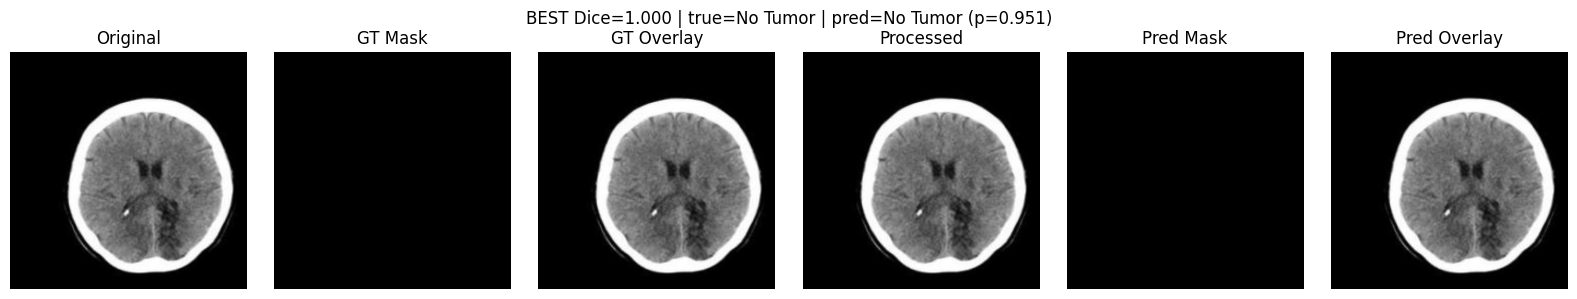

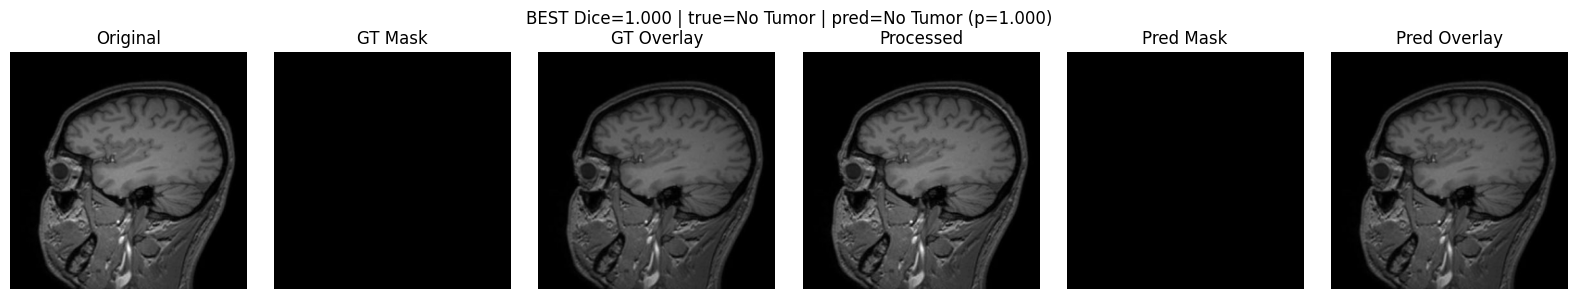


 Segmentation — Multitask U-Net: WORST examples


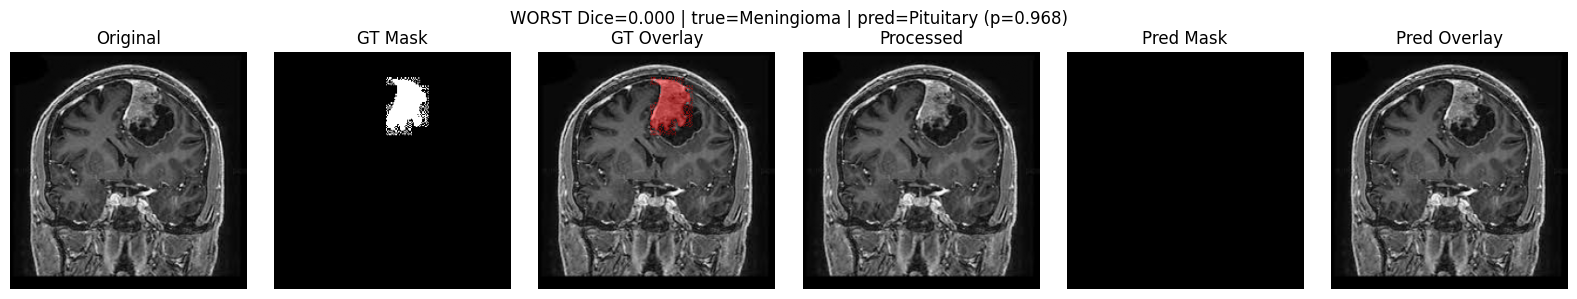

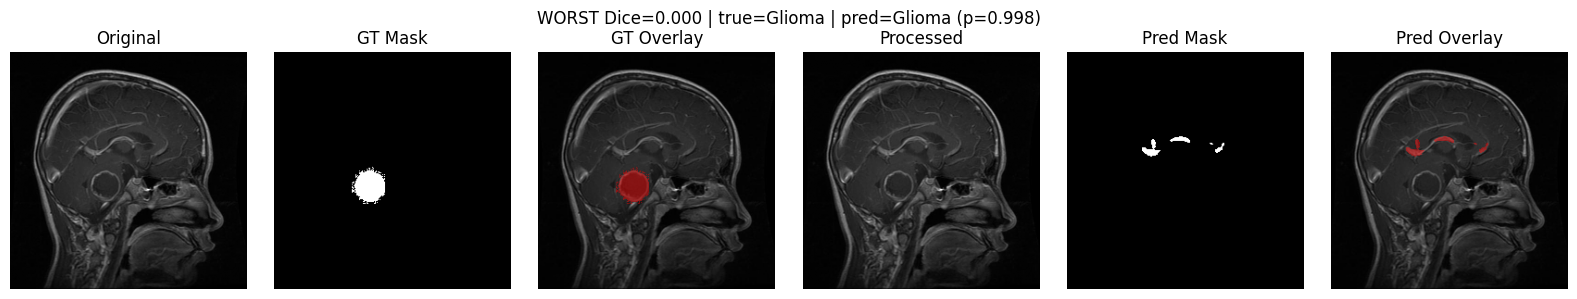


 Segmentation — Attention U-Net: BEST examples


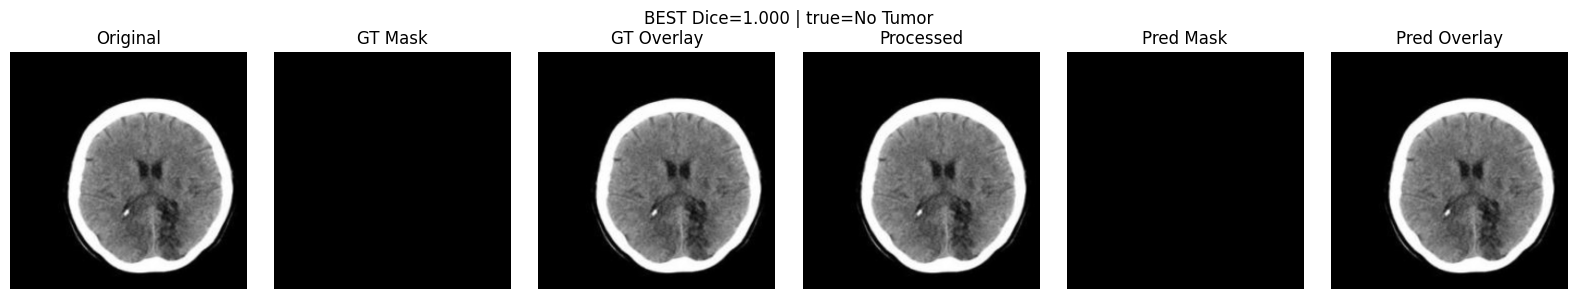

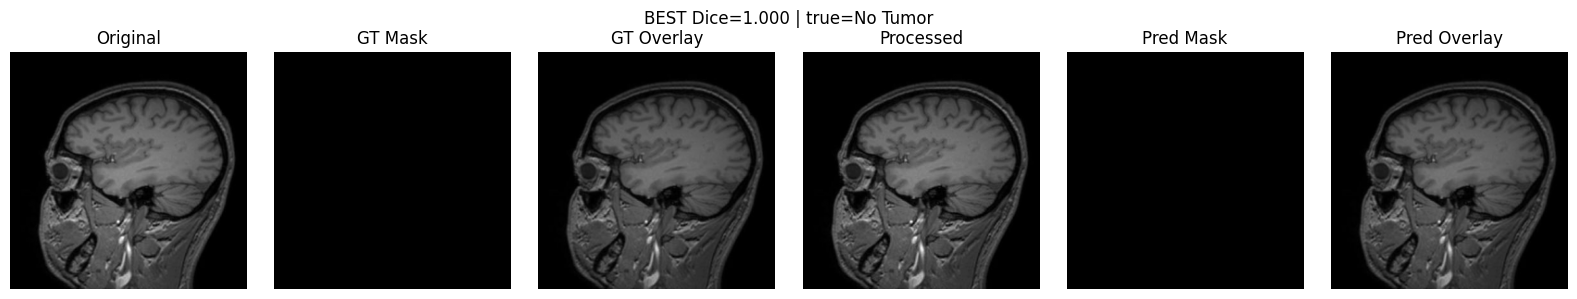


 Segmentation — Attention U-Net: WORST examples


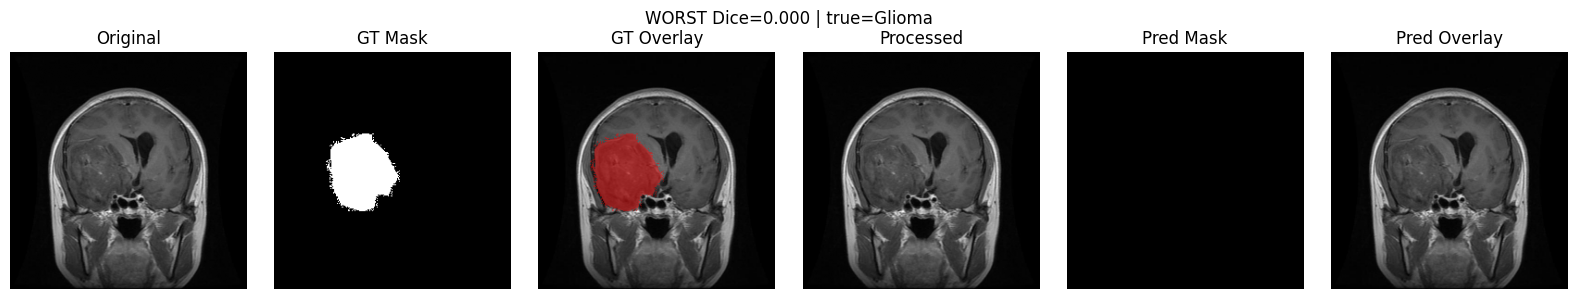

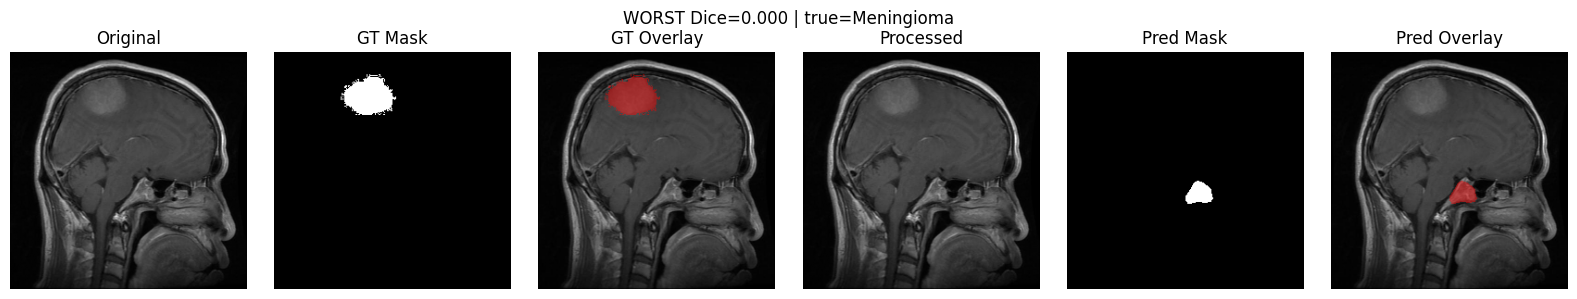


 Classification — Multitask U-Net: CORRECT predictions


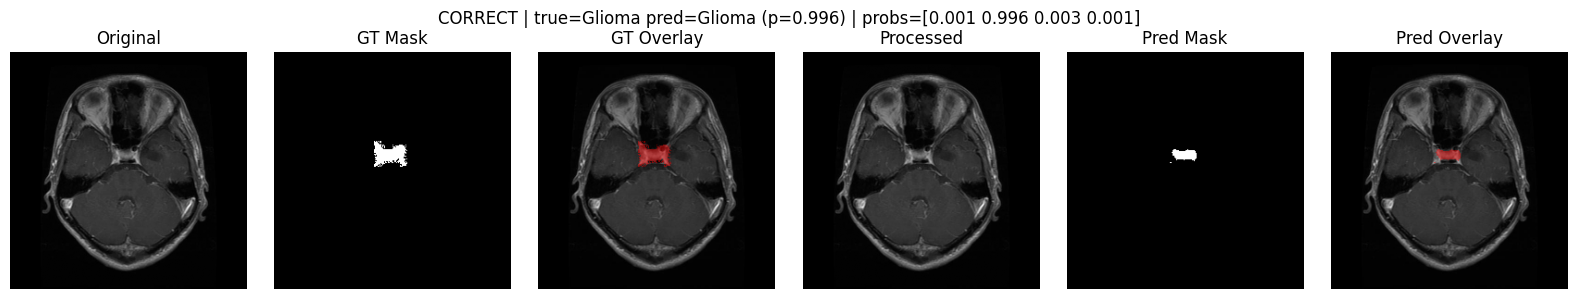

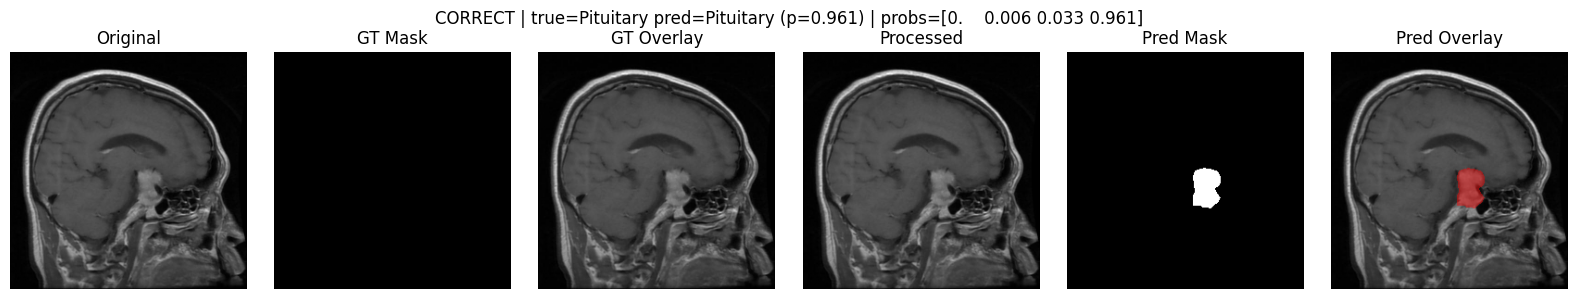


 Classification — Multitask U-Net: INCORRECT predictions


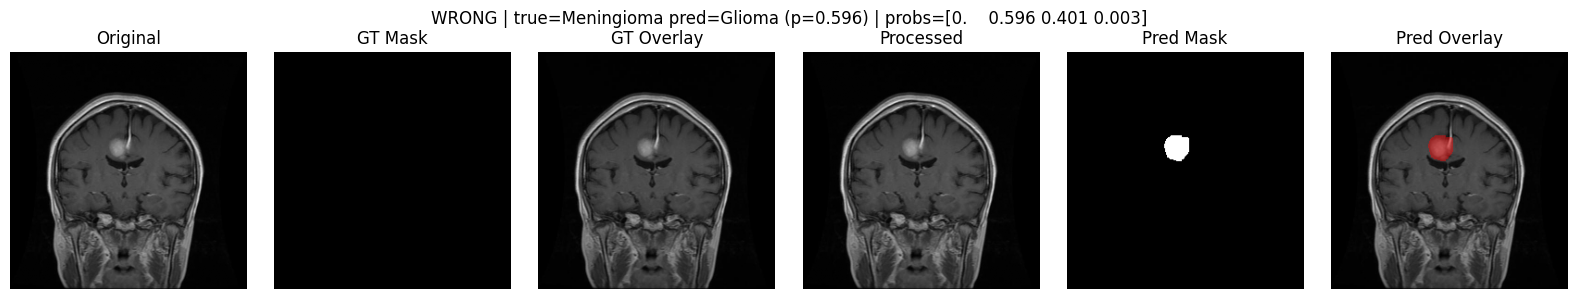

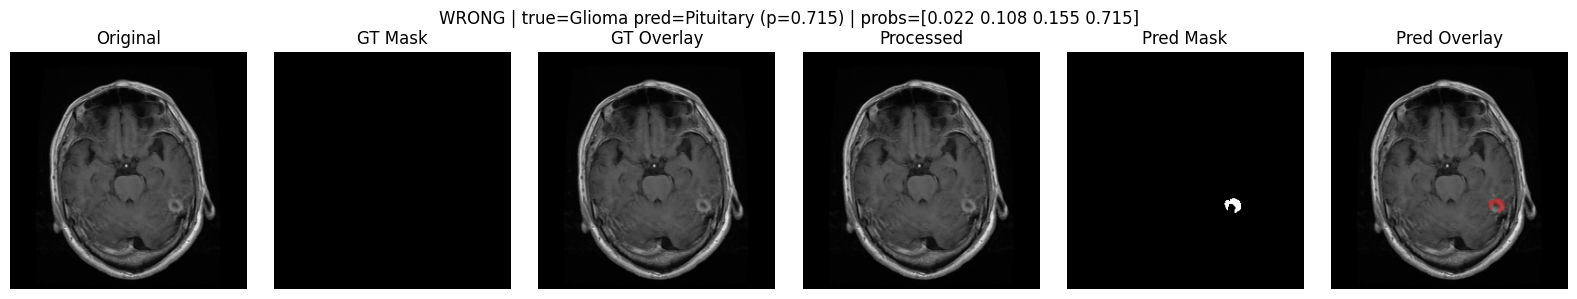

In [29]:
CLASS_NAMES = ["No Tumor", "Glioma", "Meningioma", "Pituitary"]
def _to01_from_norm(x):
    x = (x * 0.5) + 0.5
    return np.clip(x, 0, 1)

def _load_raw_image01(img_path, size=256):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        img = np.zeros((size, size), dtype=np.uint8)
    img = cv2.resize(img, (size, size), interpolation=cv2.INTER_AREA)
    return (img.astype(np.float32) / 255.0)

def _overlay(image01, mask01, alpha=0.45):
    img = np.stack([image01, image01, image01], axis=-1)
    red = np.zeros_like(img); red[..., 0] = 1.0
    m = (mask01 > 0.5).astype(np.float32)[..., None]
    out = img * (1 - alpha*m) + red * (alpha*m)
    return np.clip(out, 0, 1)

@torch.no_grad()
def _predict_one_multitask(model, x):
    seg_logits, cls_logits = model(x)
    seg = (torch.sigmoid(seg_logits)[0, 0].detach().cpu().numpy() > 0.5).astype(np.float32)

    # classification (4-class)
    probs = torch.softmax(cls_logits, dim=1)[0].detach().cpu().numpy()  # (4,)
    pred_cls = int(probs.argmax())
    pred_prob = float(probs[pred_cls])
    return seg, probs, pred_cls, pred_prob

@torch.no_grad()
def _predict_one_seg(model, x):
    seg_logits = model(x)
    seg = (torch.sigmoid(seg_logits)[0, 0].detach().cpu().numpy() > 0.5).astype(np.float32)
    return seg

def _dice_np(pred, gt, eps=1e-6):
    pred = (pred > 0.5).astype(np.float32)
    gt   = (gt > 0.5).astype(np.float32)
    inter = (pred * gt).sum()
    return float((2 * inter + eps) / (pred.sum() + gt.sum() + eps))

def _show_6panel(raw01, gt, proc01, pred, title=""):
    fig, ax = plt.subplots(1, 6, figsize=(16, 3))
    ax[0].imshow(raw01, cmap="gray"); ax[0].set_title("Original"); ax[0].axis("off")
    ax[1].imshow(gt, cmap="gray"); ax[1].set_title("GT Mask"); ax[1].axis("off")
    ax[2].imshow(_overlay(raw01, gt)); ax[2].set_title("GT Overlay"); ax[2].axis("off")
    ax[3].imshow(proc01, cmap="gray"); ax[3].set_title("Processed"); ax[3].axis("off")
    ax[4].imshow(pred, cmap="gray"); ax[4].set_title("Pred Mask"); ax[4].axis("off")
    ax[5].imshow(_overlay(raw01, pred)); ax[5].set_title("Pred Overlay"); ax[5].axis("off")
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

def qualitative_examples(test_subset, model_unet, model_att, k=3, max_scan=None):
    if max_scan is None:
        max_scan = len(test_subset)

    scan_indices = list(range(len(test_subset)))
    random.shuffle(scan_indices)
    scan_indices = scan_indices[:max_scan]

    seg_scores_unet = []
    seg_scores_att  = []
    cls_correct = []
    cls_wrong   = []

    for j, sub_i in enumerate(scan_indices):
        base_i = test_subset.indices[sub_i]
        img_path, mask_path, y, has_mask = test_subset.dataset.records[base_i]

        img_t, gt_t, label_t, has_mask_t = test_subset[sub_i]
        x = img_t.unsqueeze(0).to(DEVICE)

        pred_unet, probs, pred_cls, pred_prob = _predict_one_multitask(model_unet, x)

        true_cls = int(label_t.item())
        if pred_cls == true_cls:
            cls_correct.append((sub_i, pred_prob))
        else:
            cls_wrong.append((sub_i, pred_prob))

        if float(has_mask_t.item()) > 0.5:
            gt = gt_t[0].cpu().numpy()
            d_unet = _dice_np(pred_unet, gt)
            seg_scores_unet.append((sub_i, d_unet))

            pred_att = _predict_one_seg(model_att, x)
            d_att = _dice_np(pred_att, gt)
            seg_scores_att.append((sub_i, d_att))

    if seg_scores_unet:
        seg_scores_unet.sort(key=lambda t: t[1])
        worst_unet = seg_scores_unet[:k]
        best_unet  = seg_scores_unet[-k:][::-1]

        print("\n Segmentation — Multitask U-Net: BEST examples")
        for sub_i, d in best_unet:
            base_i = test_subset.indices[sub_i]
            img_path, _, y, has_mask = test_subset.dataset.records[base_i]
            img_t, gt_t, label_t, _ = test_subset[sub_i]
            raw01 = _load_raw_image01(img_path, IMAGE_SIZE)
            proc01 = _to01_from_norm(img_t[0].cpu().numpy())
            x = img_t.unsqueeze(0).to(DEVICE)
            pred, probs, pred_cls, pred_prob = _predict_one_multitask(model_unet, x)
            gt = gt_t[0].cpu().numpy()

            true_name = CLASS_NAMES[int(label_t.item())]
            pred_name = CLASS_NAMES[pred_cls]
            _show_6panel(
                raw01, gt, proc01, pred,
                title=f"BEST Dice={d:.3f} | true={true_name} | pred={pred_name} (p={pred_prob:.3f})"
            )

        print("\n Segmentation — Multitask U-Net: WORST examples")
        for sub_i, d in worst_unet:
            base_i = test_subset.indices[sub_i]
            img_path, _, y, has_mask = test_subset.dataset.records[base_i]
            img_t, gt_t, label_t, _ = test_subset[sub_i]
            raw01 = _load_raw_image01(img_path, IMAGE_SIZE)
            proc01 = _to01_from_norm(img_t[0].cpu().numpy())
            x = img_t.unsqueeze(0).to(DEVICE)
            pred, probs, pred_cls, pred_prob = _predict_one_multitask(model_unet, x)
            gt = gt_t[0].cpu().numpy()

            true_name = CLASS_NAMES[int(label_t.item())]
            pred_name = CLASS_NAMES[pred_cls]
            _show_6panel(
                raw01, gt, proc01, pred,
                title=f"WORST Dice={d:.3f} | true={true_name} | pred={pred_name} (p={pred_prob:.3f})"
            )

    if seg_scores_att:
        seg_scores_att.sort(key=lambda t: t[1])
        worst_att = seg_scores_att[:k]
        best_att  = seg_scores_att[-k:][::-1]

        print("\n Segmentation — Attention U-Net: BEST examples")
        for sub_i, d in best_att:
            base_i = test_subset.indices[sub_i]
            img_path, _, y, has_mask = test_subset.dataset.records[base_i]
            img_t, gt_t, label_t, _ = test_subset[sub_i]
            raw01 = _load_raw_image01(img_path, IMAGE_SIZE)
            proc01 = _to01_from_norm(img_t[0].cpu().numpy())
            x = img_t.unsqueeze(0).to(DEVICE)
            pred = _predict_one_seg(model_att, x)
            gt = gt_t[0].cpu().numpy()

            true_name = CLASS_NAMES[int(label_t.item())]
            _show_6panel(raw01, gt, proc01, pred, title=f"BEST Dice={d:.3f} | true={true_name}")

        print("\n Segmentation — Attention U-Net: WORST examples")
        for sub_i, d in worst_att:
            base_i = test_subset.indices[sub_i]
            img_path, _, y, has_mask = test_subset.dataset.records[base_i]
            img_t, gt_t, label_t, _ = test_subset[sub_i]
            raw01 = _load_raw_image01(img_path, IMAGE_SIZE)
            proc01 = _to01_from_norm(img_t[0].cpu().numpy())
            x = img_t.unsqueeze(0).to(DEVICE)
            pred = _predict_one_seg(model_att, x)
            gt = gt_t[0].cpu().numpy()

            true_name = CLASS_NAMES[int(label_t.item())]
            _show_6panel(raw01, gt, proc01, pred, title=f"WORST Dice={d:.3f} | true={true_name}")

    print("\n Classification — Multitask U-Net: CORRECT predictions")
    for sub_i, _ in cls_correct[:k]:
        base_i = test_subset.indices[sub_i]
        img_path, _, y, has_mask = test_subset.dataset.records[base_i]
        img_t, gt_t, label_t, has_mask_t = test_subset[sub_i]
        raw01 = _load_raw_image01(img_path, IMAGE_SIZE)
        proc01 = _to01_from_norm(img_t[0].cpu().numpy())
        x = img_t.unsqueeze(0).to(DEVICE)

        pred_mask, probs, pred_cls, pred_prob = _predict_one_multitask(model_unet, x)
        gt = gt_t[0].cpu().numpy()

        true_name = CLASS_NAMES[int(label_t.item())]
        pred_name = CLASS_NAMES[pred_cls]
        title = f"CORRECT | true={true_name} pred={pred_name} (p={pred_prob:.3f}) | probs={np.round(probs,3)}"
        _show_6panel(raw01, gt, proc01, pred_mask, title=title)

    print("\n Classification — Multitask U-Net: INCORRECT predictions")
    for sub_i, _ in cls_wrong[:k]:
        base_i = test_subset.indices[sub_i]
        img_path, _, y, has_mask = test_subset.dataset.records[base_i]
        img_t, gt_t, label_t, has_mask_t = test_subset[sub_i]
        raw01 = _load_raw_image01(img_path, IMAGE_SIZE)
        proc01 = _to01_from_norm(img_t[0].cpu().numpy())
        x = img_t.unsqueeze(0).to(DEVICE)

        pred_mask, probs, pred_cls, pred_prob = _predict_one_multitask(model_unet, x)
        gt = gt_t[0].cpu().numpy()

        true_name = CLASS_NAMES[int(label_t.item())]
        pred_name = CLASS_NAMES[pred_cls]
        title = f"WRONG | true={true_name} pred={pred_name} (p={pred_prob:.3f}) | probs={np.round(probs,3)}"
        _show_6panel(raw01, gt, proc01, pred_mask, title=title)

needed = ["test_set", "model_unet", "model_att"]

ok = True
for k in needed:
    if k not in globals():
        ok = False
        break

if ok:
    qualitative_examples(test_set, model_unet, model_att, k=2, max_scan=400)
else:
    print("Run MAIN EXECUTION first.")


## 12. Demonstration Block (Any Image Path, 6-panel Output)

Running random demos on the test split (different images each run).


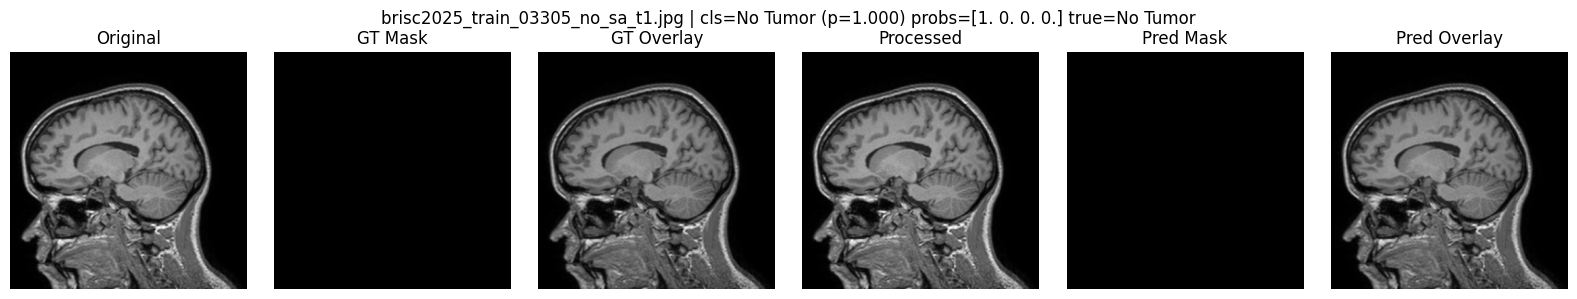

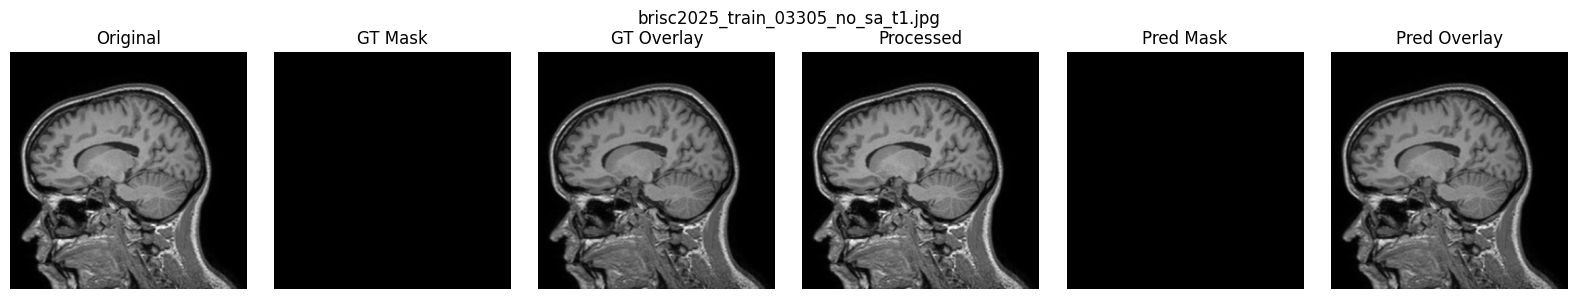

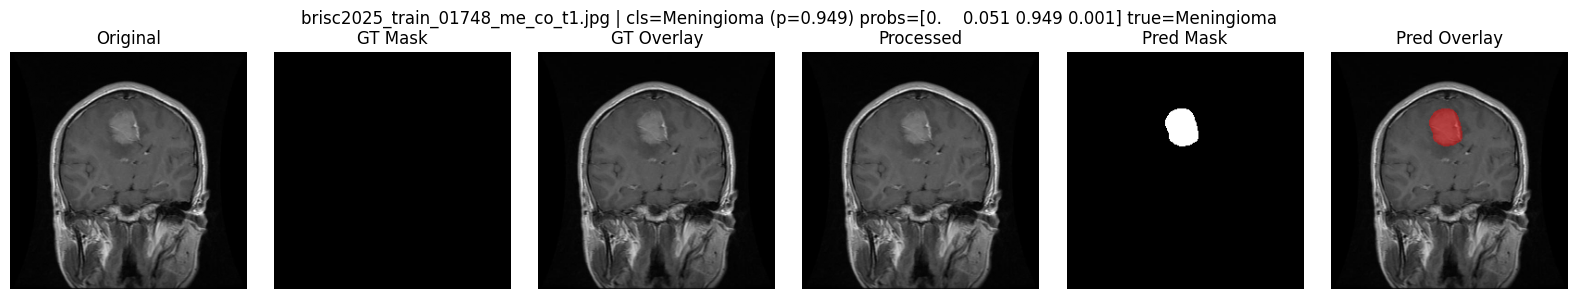

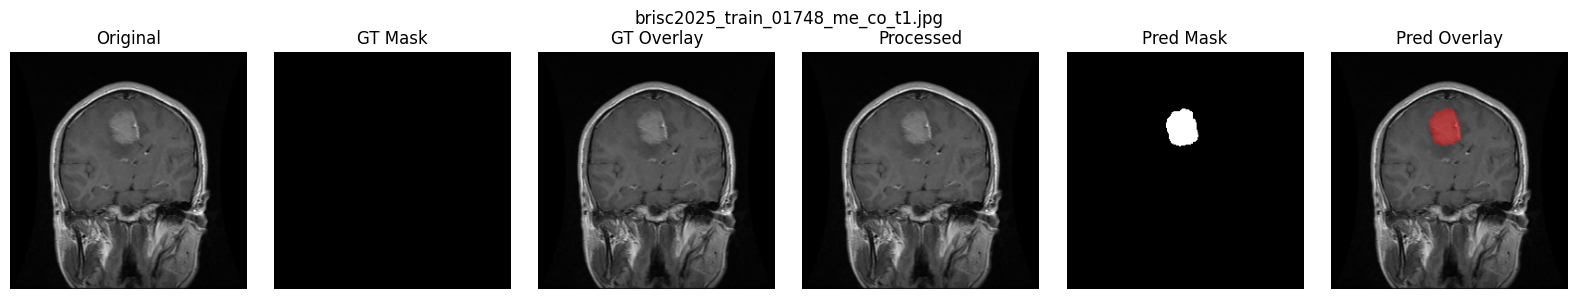

In [30]:
def build_infer_transform(img_size):
    return A.Compose([
        A.Resize(img_size, img_size),
        A.Normalize(mean=(0.5,), std=(0.5,)),
        ToTensorV2()
    ])

INFER_TFM = build_infer_transform(IMAGE_SIZE)

def _apply_optional_preprocess(image_u8):
    if globals().get("ENABLE_DENOISE", False):
        m = str(globals().get("DENOISE_METHOD", "median")).lower()
        if m == "median":
            image_u8 = cv2.medianBlur(image_u8, 3)
        elif m == "gaussian":
            image_u8 = cv2.GaussianBlur(image_u8, (3, 3), 0)
    return image_u8

def _load_u8_gray(path, fallback_size=256):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        img = np.zeros((fallback_size, fallback_size), dtype=np.uint8)
    return img

def _to01_from_norm(x):
    x = (x * 0.5) + 0.5
    return np.clip(x, 0, 1)

def _overlay(image01, mask01, alpha=0.45):
    img = np.stack([image01, image01, image01], axis=-1)
    red = np.zeros_like(img); red[..., 0] = 1.0
    m = (mask01 > 0.5).astype(np.float32)[..., None]
    return np.clip(img * (1 - alpha*m) + red * (alpha*m), 0, 1)

def _dice_iou_np(pred, gt, eps=1e-6):
    pred = (pred > 0.5).astype(np.float32)
    gt   = (gt > 0.5).astype(np.float32)
    inter = (pred * gt).sum()
    dice = (2*inter + eps) / (pred.sum() + gt.sum() + eps)
    union = pred.sum() + gt.sum() - inter
    iou = (inter + eps) / (union + eps)
    return float(dice), float(iou)

@torch.no_grad()
def demo_on_image_path(
    image_path,
    mask_path=None,
    label=None,              
    model_multitask=None,
    model_attention=None,
):
    assert os.path.exists(image_path), f"Image not found: {image_path}"

    raw_u8 = _load_u8_gray(image_path, fallback_size=IMAGE_SIZE)
    raw_u8 = _apply_optional_preprocess(raw_u8)

    if mask_path is not None and os.path.exists(mask_path):
        gt_u8 = _load_u8_gray(mask_path, fallback_size=IMAGE_SIZE)
    else:
        gt_u8 = np.zeros_like(raw_u8, dtype=np.uint8)

    augmented = INFER_TFM(image=raw_u8, mask=gt_u8)
    img_t = augmented["image"]
    m_t   = augmented["mask"]

    if img_t.ndim == 2:
        img_t = img_t.unsqueeze(0)   
    if m_t.ndim == 2:
        m_t = m_t.unsqueeze(0)       

    x = img_t.unsqueeze(0).to(DEVICE)  

    proc01 = _to01_from_norm(img_t[0].cpu().numpy())
    raw01 = cv2.resize(raw_u8, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA).astype(np.float32) / 255.0
    gt = (m_t[0].cpu().numpy() > 0.5).astype(np.float32)

    pred_mask = None
    cls_probs = None      
    cls_pred = None        
    cls_conf = None        

    if model_multitask is not None:
        model_multitask = model_multitask.to(DEVICE).eval()
        seg_logits, cls_logits = model_multitask(x)

        pred_mask = (torch.sigmoid(seg_logits)[0, 0].cpu().numpy() > 0.5).astype(np.float32)
        cls_probs = torch.softmax(cls_logits, dim=1)[0].detach().cpu().numpy()  
        cls_pred = int(cls_probs.argmax())
        cls_conf = float(cls_probs[cls_pred])

    if (pred_mask is None) and (model_attention is not None):
        model_attention = model_attention.to(DEVICE).eval()
        seg_logits = model_attention(x)
        pred_mask = (torch.sigmoid(seg_logits)[0, 0].cpu().numpy() > 0.5).astype(np.float32)

    if pred_mask is None:
        raise ValueError("Provide at least one model: model_multitask or model_attention")

    has_gt_mask = (mask_path is not None and os.path.exists(mask_path))
    metrics_txt = ""
    if has_gt_mask:
        dice, iou = _dice_iou_np(pred_mask, gt)
        metrics_txt = f" | Dice={dice:.3f} IoU={iou:.3f}"

    cls_txt = ""
    if cls_probs is not None:
        pred_name = CLASS_NAMES[cls_pred]
        cls_txt = f" | cls={pred_name} (p={cls_conf:.3f}) probs={np.round(cls_probs,3)}"
        if label is not None:
            true_idx = int(label)
            true_name = CLASS_NAMES[true_idx] if 0 <= true_idx < len(CLASS_NAMES) else str(true_idx)
            cls_txt += f" true={true_name}"

    title = os.path.basename(image_path) + metrics_txt + cls_txt

    fig, ax = plt.subplots(1, 6, figsize=(16, 3))
    ax[0].imshow(raw01, cmap="gray"); ax[0].set_title("Original"); ax[0].axis("off")
    ax[1].imshow(gt, cmap="gray"); ax[1].set_title("GT Mask"); ax[1].axis("off")
    ax[2].imshow(_overlay(raw01, gt)); ax[2].set_title("GT Overlay"); ax[2].axis("off")
    ax[3].imshow(proc01, cmap="gray"); ax[3].set_title("Processed"); ax[3].axis("off")
    ax[4].imshow(pred_mask, cmap="gray"); ax[4].set_title("Pred Mask"); ax[4].axis("off")
    ax[5].imshow(_overlay(raw01, pred_mask)); ax[5].set_title("Pred Overlay"); ax[5].axis("off")
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()


def demo_random_from_dataset(dataset_subset, n=3):
    idxs = random.sample(range(len(dataset_subset)), k=min(n, len(dataset_subset)))

    for sub_i in idxs:
        base_i = dataset_subset.indices[sub_i]
        img_path, mask_path, y, has_mask = dataset_subset.dataset.records[base_i]

        demo_on_image_path(
            image_path=img_path,
            mask_path=mask_path,
            label=int(y),
            model_multitask=globals().get("model_unet", None),
            model_attention=None,
        )

        demo_on_image_path(
            image_path=img_path,
            mask_path=mask_path,
            label=int(y),
            model_multitask=None,
            model_attention=globals().get("model_att", None),
        )

if "test_set" in globals():
    print("Running random demos on the test split (different images each run).")
    demo_random_from_dataset(test_set, n=2)
else:
    print("Run MAIN EXECUTION first.")
